In [32]:
import os
import shutil
from datetime import datetime
import json

import h5py
import matplotlib.pyplot as plt
import numpy as np

In [33]:
def backup_data(data_filename):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename_only = os.path.basename(data_filename)
    name, ext = os.path.splitext(filename_only)
    backup_name = f"{name}_{timestamp}{ext}"
    backup_path = os.path.join('data_backups', backup_name)
    shutil.copy2(data_filename, backup_path)

def save_nested_dict_to_hdf5(filename, data, save_backup=True):

    if save_backup:
        backup_data(filename)

    with h5py.File(filename, 'w') as f:
        def _save_dict(group, dictionary):
            for key, value in dictionary.items():
                if isinstance(value, dict):
                    subgroup = group.create_group(str(key))
                    _save_dict(subgroup, value)
                elif isinstance(value, np.ndarray):
                    group.create_dataset(key, data=value, compression='gzip')
                elif isinstance(value, list):
                    group.create_dataset(key, data=np.array(value), compression='gzip')
                else:
                    group.attrs[key] = value  # Store scalars as attributes
        
        _save_dict(f, data)

def update_data_file(filename, data, keys, save_backup=True):
    if save_backup:
        backup_data(filename)
    
    with h5py.File(filename, 'a') as f:  # Open in append mode
        def _navigate_to_parent(group, key_path):
            """Navigate to the parent group of the target location"""
            current_group = group
            for key in key_path[:-1]:  # All keys except the last one
                if str(key) in current_group:
                    current_group = current_group[str(key)]
                else:
                    # Create the group if it doesn't exist
                    current_group = current_group.create_group(str(key))
            return current_group
        
        def _save_data_at_location(group, key, value):
            """Save data at a specific location, replacing if it exists"""
            # Remove existing data if it exists
            if key in group:
                del group[key]
            
            # Save new data
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                _save_dict(subgroup, value)
            elif isinstance(value, np.ndarray):
                group.create_dataset(key, data=value, compression='gzip')
            elif isinstance(value, list):
                group.create_dataset(key, data=np.array(value), compression='gzip')
            else:
                group.attrs[key] = value  # Store scalars as attributes
        
        def _save_dict(group, dictionary):
            """Helper function to save nested dictionaries"""
            for key, value in dictionary.items():
                _save_data_at_location(group, str(key), value)
        
        # Navigate to the parent location
        parent_group = _navigate_to_parent(f, keys)
        
        # Save the data at the final key location
        final_key = str(keys[-1])
        _save_data_at_location(parent_group, final_key, data)

In [57]:
def load_nested_dict_from_hdf5(filename):
    def _load_dict(group):
        result = {}
        for key in group.keys():
            if isinstance(group[key], h5py.Group):
                result[key] = _load_dict(group[key])
            else:
                result[key] = group[key][()]  # Load dataset
        
        # Load attributes (scalars)
        for key, value in group.attrs.items():
            result[key] = value
            
        return result
    
    with h5py.File(filename, 'r') as f:
        return _load_dict(f)

def print_tree(data, max_level=None):
    def __print_tree_recursive(root, level=0):
        if isinstance(root, dict):
            if not max_level is None and level == max_level:
                return
            level_str = '- '*level
            for key in root:
                print(f'{level_str}{key}')
                __print_tree_recursive(root[key], level+1)
    __print_tree_recursive(data)

In [ ]:
# new_data = {}
# new_data['data'] = data

# save_nested_dict_to_hdf5(data_filename, new_data)

In [68]:
data_filename = 'current_correlations_data.h5'

data = load_nested_dict_from_hdf5(data_filename)

In [69]:
print_tree(data, max_level=3)

data
- coupling_point_2
- - highest
- coupling_point_4
- - highest
simulation
- coupling_point_2
- - highest


# 1. Plot Single Coupling Point

In [74]:
coupling_point = 'coupling_point_2'
coupling_point = 'coupling_point_4'

eigenstate = 'highest'

In [81]:
correlation_pairs = []

for i in range(1, 6):
    for j in range(i+2, 8):
        correlation_pairs.append(((i,i+1),(j,j+1)))

print(correlation_pairs)
print(len(correlation_pairs))

[((1, 2), (3, 4)), ((1, 2), (4, 5)), ((1, 2), (5, 6)), ((1, 2), (6, 7)), ((1, 2), (7, 8)), ((2, 3), (4, 5)), ((2, 3), (5, 6)), ((2, 3), (6, 7)), ((2, 3), (7, 8)), ((3, 4), (5, 6)), ((3, 4), (6, 7)), ((3, 4), (7, 8)), ((4, 5), (6, 7)), ((4, 5), (7, 8)), ((5, 6), (7, 8))]
15


### 1.1 Plot Current Correlation vs Time

In [77]:
correlation_pairs = []
correlation_pairs.append(((1,2),(3,4)))
correlation_pairs.append(((2,3),(4,5)))
correlation_pairs.append(((3,4),(5,6)))
correlation_pairs.append(((4,5),(6,7)))
correlation_pairs.append(((5,6),(7,8)))

dict_keys(['current_correlation', 'times', 'beamsplitter_time', 'current_correlation_value'])


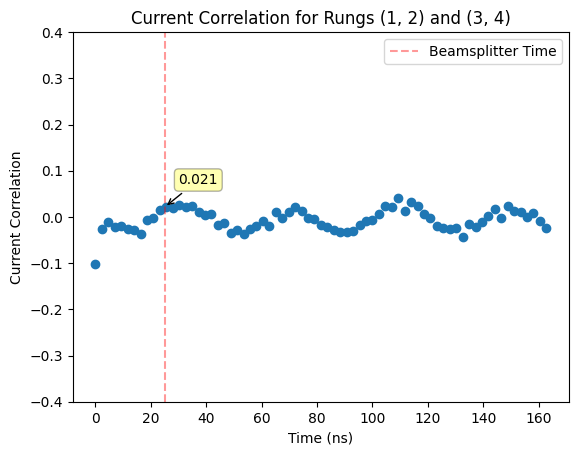

dict_keys(['current_correlation', 'times', 'beamsplitter_time', 'current_correlation_value'])


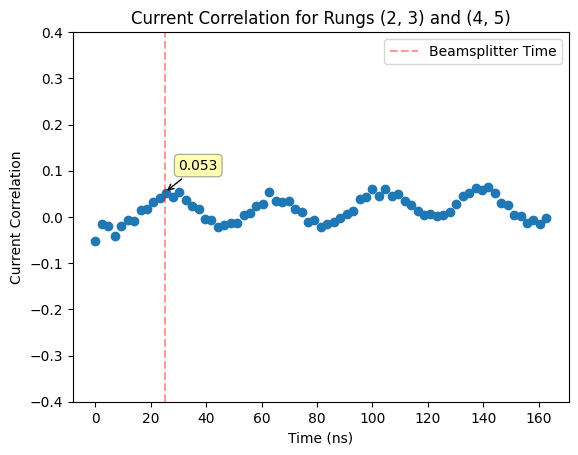

dict_keys(['current_correlation', 'times', 'beamsplitter_time', 'current_correlation_value'])


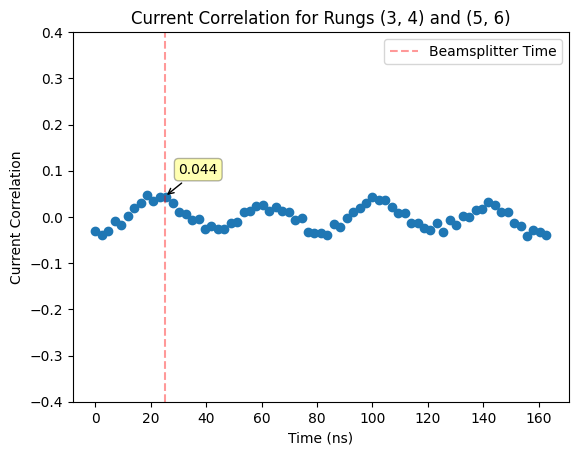

dict_keys(['current_correlation', 'times', 'beamsplitter_time', 'current_correlation_value'])


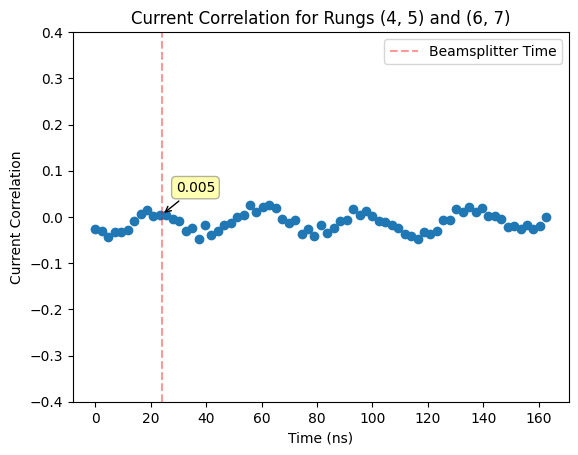

dict_keys(['current_correlation', 'times', 'beamsplitter_time', 'current_correlation_value'])


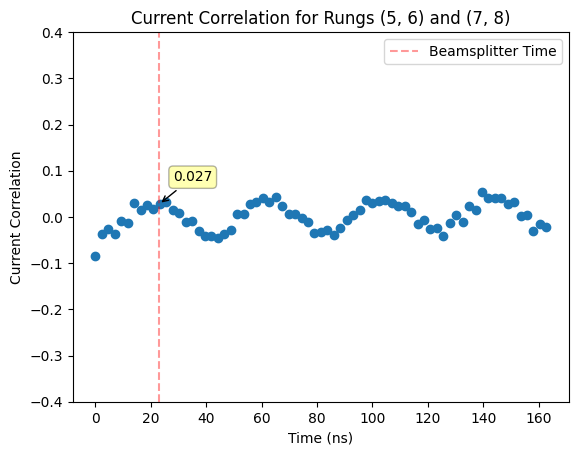

In [78]:
for correlation_pair in correlation_pairs:

    correlation_pair_data = data['data'][coupling_point]['highest'][str(correlation_pair)]

    print(correlation_pair_data.keys())

    times = correlation_pair_data['times']
    beamsplitter_time = correlation_pair_data['beamsplitter_time']

    current_correlation = correlation_pair_data['current_correlation']
    current_correlation_value = correlation_pair_data['current_correlation_value']

    plt.plot(times, current_correlation, linestyle='', marker='o')

    plt.axvline(beamsplitter_time, color='r', alpha=0.4, linestyle='--', label='Beamsplitter Time')
   
    plt.xlabel('Time (ns)')
    plt.ylabel('Current Correlation')
    plt.title(f'Current Correlation for Rungs {correlation_pair[0]} and {correlation_pair[1]}')
    plt.legend()

    plt.annotate(f'{current_correlation_value:.3f}',
                 xy=(beamsplitter_time, current_correlation_value),
                 xytext=(beamsplitter_time + 5, current_correlation_value + 0.05),
                 arrowprops=dict(arrowstyle='->', color='black'),
                 bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3))

    plt.ylim(-0.4, 0.4)

    plt.show()


### 1.2 Plot Current Correlation by distance

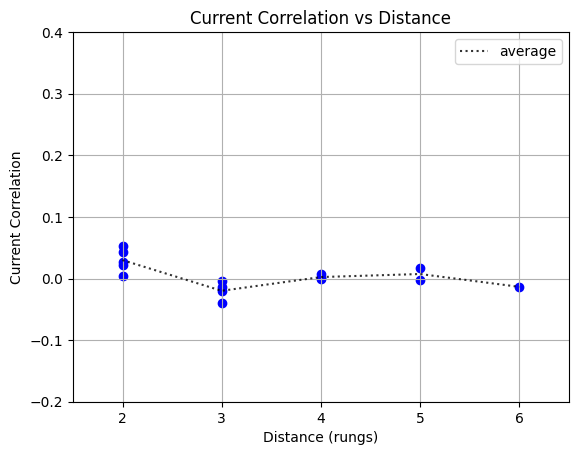

In [84]:
current_correlation_by_distance = {}


for correlation_pair in correlation_pairs:

    correlation_pair_data = data['data'][coupling_point]['highest'][str(correlation_pair)]

    current_correlation_value = correlation_pair_data['current_correlation_value']

    distance = abs(min(correlation_pair[0]) - min(correlation_pair[1]))

    if not distance in current_correlation_by_distance:
        current_correlation_by_distance[distance] = []
    
    current_correlation_by_distance[distance].append(current_correlation_value)


distances = []
current_correlation_averages = []

for distance in current_correlation_by_distance:
    distances.append(distance)
    current_correlation_averages.append(np.mean(current_correlation_by_distance[distance]))

# plot
for distance in current_correlation_by_distance:
    plt.scatter([distance]*len(current_correlation_by_distance[distance]), current_correlation_by_distance[distance], color='b')

plt.plot(distances, current_correlation_averages, linestyle=':', color='black', alpha=0.8, label='average')

plt.xlabel('Distance (rungs)')
plt.xticks([2, 3, 4, 5, 6])


plt.ylabel('Current Correlation')

plt.legend()

plt.xlim(1.5, 6.5)
plt.ylim(-0.2, 0.4)

plt.grid()

plt.title('Current Correlation vs Distance')



plt.show()